This document only contains some codes that I have succeeded, because this data set is too weird and huge (the proportion of missing data is too high), I tried many methods without success.

I have relatively little explanation of the code, if you have any questions, please @me.

In [9]:
setwd("D:\\dst\\assessment2")
conndata<-read.table("1_percent_data.csv.gz", sep=",", header=TRUE, na.strings=c("","NA"))

In [10]:
for(i in c(3,5,8,9,10,12,14:17)) conndata[,i]=as.numeric(conndata[,i])
for(i in c(2,4,6,11,13)) conndata[,i]=as.factor(conndata[,i])
conndata1<-conndata
head(conndata1)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,0.03,481,8133,RSTO,0,ShADadfR,8,813,9,8505
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,NA,NA,NA,NA,REJ,0,Sr,1,48,1,40
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,NA,NA,NA,NA,REJ,0,Sr,1,60,1,40
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,NA,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,NA,NA,NA,NA,S0,0,S,1,48,0,0
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,NA,NA,NA,NA,REJ,0,Sr,1,60,1,40


#### Observing missing values

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,duration,orig_bytes,resp_bytes,service,
5172,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
33866,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
1614,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,3
186291,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,4
,0,0,0,0,0,0,0,0,0,0,0,0,0,187905,187905,187905,220157,783872


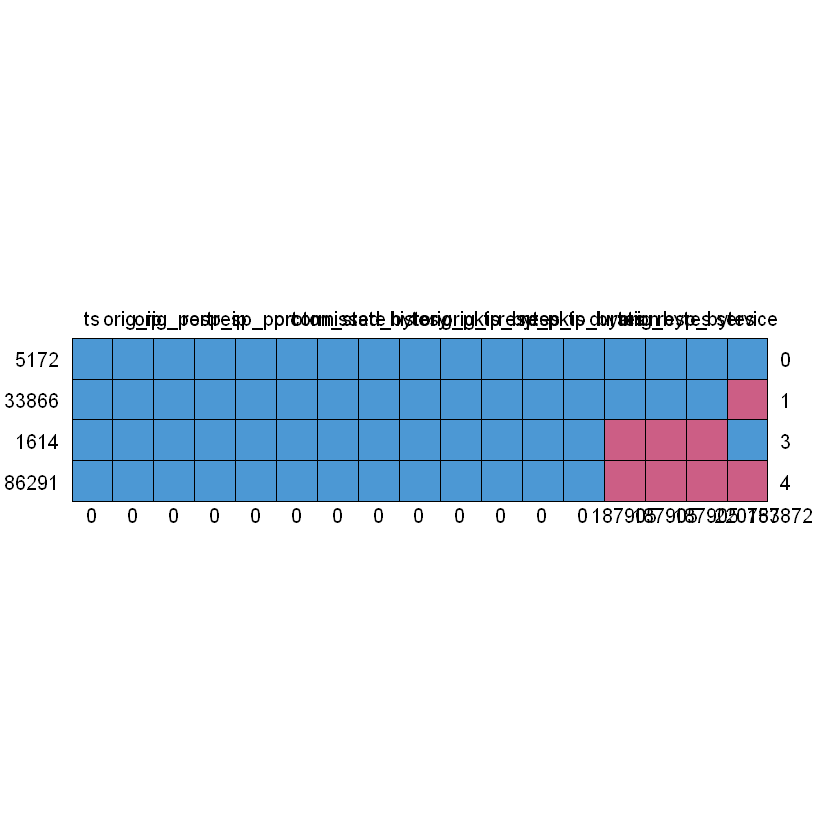

In [4]:
library("mice")
md.pattern(conndata1)

Warning message in plot.aggr(res, ...):
"not enough horizontal space to display frequencies"


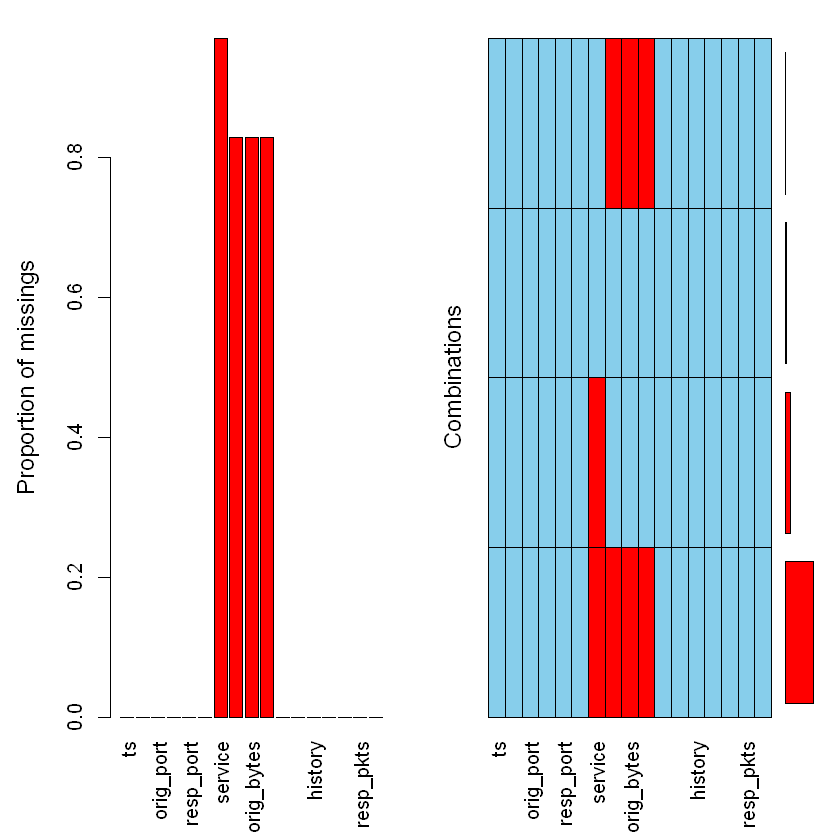

In [7]:
library("VIM")
aggr(conndata1, prop = TRUE, numbers = TRUE)

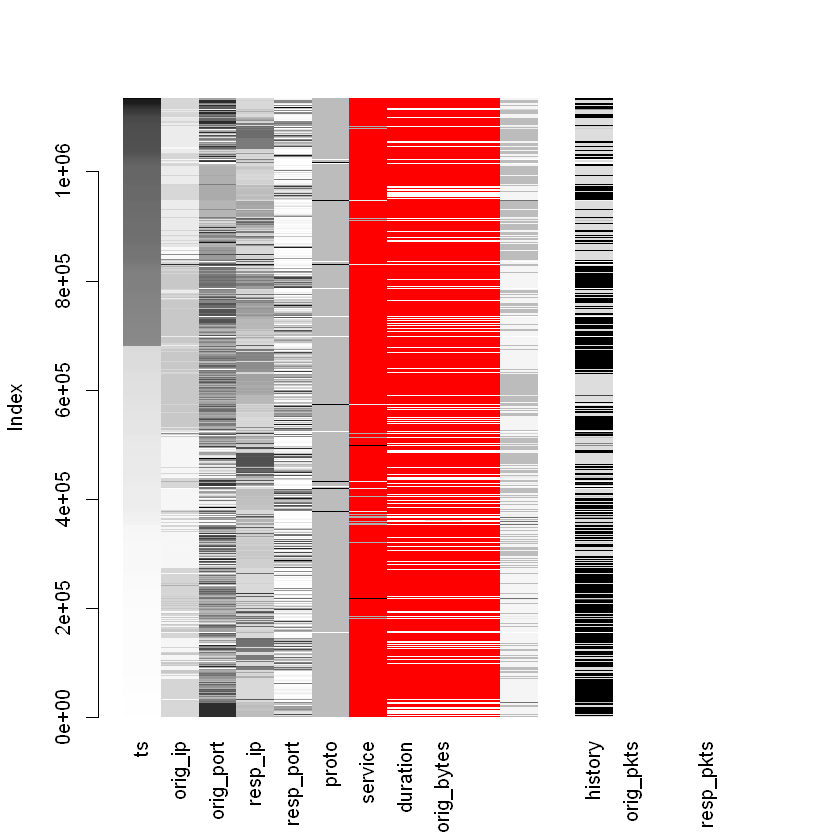

In [8]:
matrixplot(conndata1,sortby = "ts")

We delete the "service" column

In [11]:
conndata2<-conndata[,-which(names(conndata) %in% c("service"))]
head(conndata2)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,0.03,481,8133,RSTO,0,ShADadfR,8,813,9,8505
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,NA,NA,NA,REJ,0,Sr,1,48,1,40
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,NA,NA,NA,REJ,0,Sr,1,60,1,40
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,NA,NA,NA,S0,0,S,1,48,0,0
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,NA,NA,NA,REJ,0,Sr,1,60,1,40


One way to examine the imputation model's performance is by how much variation it explains.
We build a simple linear regression model, through this model, we can see the fit of "duration" and other variables. The closer the R-squared is to 1, the better the fit of the data, that is, the better the effect of imputation.

In [12]:
conndata2[,"logduration"]=log(conndata2[,"duration"])
lm1=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conndata2)
summary(lm1) 


Call:
lm(formula = logduration ~ proto + ts + orig_port + resp_port + 
    conn_state + orig_pkts + orig_ip_bytes + resp_pkts + resp_ip_bytes, 
    data = conndata2)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.5188  -0.9836  -0.4615   0.6292  12.3354 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     9.011e+03  2.293e+02  39.305  < 2e-16 ***
prototcp        1.779e+00  2.237e-01   7.952 1.89e-15 ***
protoudp        1.974e+00  2.330e-01   8.470  < 2e-16 ***
ts             -6.765e-06  1.721e-07 -39.307  < 2e-16 ***
orig_port      -9.129e-06  4.134e-07 -22.085  < 2e-16 ***
resp_port      -8.783e-07  3.818e-07  -2.300   0.0214 *  
conn_stateREJ  -4.676e+00  2.210e-01 -21.163  < 2e-16 ***
conn_stateRSTO -4.450e+00  2.221e-01 -20.037  < 2e-16 ***
conn_stateRSTR -2.785e+00  2.274e-01 -12.249  < 2e-16 ***
conn_stateS0   -1.156e-01  2.241e-01  -0.516   0.6061    
conn_stateS1    1.891e+00  3.547e-01   5.331 9.80e-08 ***
conn_stateS2    2.

#### Method 1: Deleting data with missing values

In [13]:
conn_delete<-conndata2[complete.cases(conndata2),] 

In [14]:
lm_delete=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_delete)
summary(lm_delete) 


Call:
lm(formula = logduration ~ proto + ts + orig_port + resp_port + 
    conn_state + orig_pkts + orig_ip_bytes + resp_pkts + resp_ip_bytes, 
    data = conn_delete)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.5188  -0.9836  -0.4615   0.6292  12.3354 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     9.011e+03  2.293e+02  39.305  < 2e-16 ***
prototcp        1.779e+00  2.237e-01   7.952 1.89e-15 ***
protoudp        1.974e+00  2.330e-01   8.470  < 2e-16 ***
ts             -6.765e-06  1.721e-07 -39.307  < 2e-16 ***
orig_port      -9.129e-06  4.134e-07 -22.085  < 2e-16 ***
resp_port      -8.783e-07  3.818e-07  -2.300   0.0214 *  
conn_stateREJ  -4.676e+00  2.210e-01 -21.163  < 2e-16 ***
conn_stateRSTO -4.450e+00  2.221e-01 -20.037  < 2e-16 ***
conn_stateRSTR -2.785e+00  2.274e-01 -12.249  < 2e-16 ***
conn_stateS0   -1.156e-01  2.241e-01  -0.516   0.6061    
conn_stateS1    1.891e+00  3.547e-01   5.331 9.80e-08 ***
conn_stateS2    

Since most of the data have missing values, this method is too simple and crude, and is not suitable for use in practice

#### Method 2: Mean imputation

In [15]:
conn_mean<-conndata2
conn_mean[is.na(conn_mean[,"logduration"]),
              "logduration"]=
    mean(na.omit(conn_mean[,"logduration"]))

In [16]:
lm_mean=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_mean)
summary(lm_mean)


Call:
lm(formula = logduration ~ proto + ts + orig_port + resp_port + 
    conn_state + orig_pkts + orig_ip_bytes + resp_pkts + resp_ip_bytes, 
    data = conn_mean)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.0928  -0.0824   0.0241   0.1229  12.8767 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.593e+03  4.716e+01  33.770  < 2e-16 ***
prototcp         -2.143e+00  2.419e-02 -88.584  < 2e-16 ***
protoudp         -1.000e+00  2.872e-02 -34.814  < 2e-16 ***
ts               -1.196e-06  3.541e-08 -33.788  < 2e-16 ***
orig_port        -1.444e-06  1.004e-07 -14.386  < 2e-16 ***
resp_port        -2.342e-06  7.291e-08 -32.123  < 2e-16 ***
conn_stateREJ    -1.587e-01  1.741e-02  -9.119  < 2e-16 ***
conn_stateRSTO   -2.316e-01  2.009e-02 -11.527  < 2e-16 ***
conn_stateRSTOS0  6.724e-03  6.964e-01   0.010    0.992    
conn_stateRSTR    9.268e-01  3.164e-02  29.288  < 2e-16 ***
conn_stateRSTRH  -1.083e-02  2.468e-01  -0.044    0.96

R-squared decreases, indicating that the effect of the mean imputation is not good.

#### Method 3: MissForest imputation
The function 'missForest' is used to impute missing values particularly in the case of mixed-type data. It uses a random forest trained on the observed values of a data matrix to predict the missing values. It can be used to impute continuous and/or categorical data including complex interactions and non-linear relations. It yields an out-of-bag (OOB) imputation error estimate without the need of a test set or elaborate cross-validation.

We first make an initial guess for the missing value, for instance, replace it with the mean/median replacement, and then sort the variable from small to large according to the missing rate of the variable, first use random forest regression for the variable with the small missing rate to replace the missing value of the variable , And then iterate until the latest replacement result and the last replacement result no longer change (the change is small).

In [19]:
library("missForest")
conndata2<-conndata[,-which(names(conndata) %in% c("service","orig_ip","resp_ip","history"))]
set.seed(81)
conn_imp <- missForest(conndata2, verbose = TRUE,maxiter = 10, ntree = 100)
conn_forest<-conn_imp$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.01858368 0 
    difference(s): 0.0003304282 0 
    time: 278.1 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.01871791 0 
    difference(s): 0.0001536129 0 
    time: 223.68 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.01985061 0 
    difference(s): 0.0001354906 0 
    time: 227.57 seconds

  missForest iteration 4 in progress...done!
    estimated error(s): 0.01882613 0 
    difference(s): 0.0001116969 0 
    time: 229.78 seconds

  missForest iteration 5 in progress...done!
    estimated error(s): 0.01899781 0 
    difference(s): 0.0001082856 0 
    time: 225.54 seconds

  missForest iteration 6 in progress...done!
    estimated error(s): 0.01946173 0 
    difference(s): 5.512473e-05 0 
    time: 231.21 seconds

  missForest iteration 7 in progress...done!
    estimated error(s): 0.02026443 0 
    difference(s): 0.0002509467 0 
    time: 229.64 se

In [20]:
head(conn_forest)

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,0.03000000,4.810000e+02,8.133000e+03,RSTO,0,8,813,9,8505
2,1331923392,11574,1724,tcp,0.13652842,5.329191e-04,-1.996011e-10,REJ,0,1,48,1,40
3,1331905217,41267,8010,tcp,0.05152906,5.290888e-04,-1.982710e-10,REJ,0,1,60,1,40
4,1331994375,58519,5214,tcp,0.02442885,5.329181e-04,-1.991930e-10,REJ,0,1,60,1,40
5,1331999507,25774,1625,tcp,30.07244441,1.684881e+07,1.962527e+03,S0,0,1,48,0,0
6,1331935766,60760,1580,tcp,0.02745513,5.329181e-04,-2.006789e-10,REJ,0,1,60,1,40


In [18]:
conn_forest[,"logduration"]=log(conn_forest[,"duration"])
lm_forest=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest)
summary(lm_forest)


Call:
lm(formula = logduration ~ proto + ts + orig_port + resp_port + 
    conn_state + orig_pkts + orig_ip_bytes + resp_pkts + resp_ip_bytes, 
    data = conn_forest)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.8117  -0.7712  -0.2903   0.7656  11.0678 

Coefficients:
                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)      -2.149e+03  7.673e+01  -28.006  < 2e-16 ***
prototcp          3.340e+00  3.936e-02   84.849  < 2e-16 ***
protoudp          2.392e+00  4.673e-02   51.174  < 2e-16 ***
ts                1.613e-06  5.761e-08   28.002  < 2e-16 ***
orig_port        -2.017e-06  1.633e-07  -12.348  < 2e-16 ***
resp_port        -6.139e-06  1.186e-07  -51.752  < 2e-16 ***
conn_stateREJ    -6.041e+00  2.832e-02 -213.317  < 2e-16 ***
conn_stateRSTO   -5.352e+00  3.269e-02 -163.715  < 2e-16 ***
conn_stateRSTOS0  2.818e-01  1.133e+00    0.249  0.80360    
conn_stateRSTR   -4.945e+00  5.149e-02  -96.039  < 2e-16 ***
conn_stateRSTRH  -7.332e-01  4.015e-01   

In [43]:
conn_imp$OOBerror

NRMSE        PFC 
0.01946173 0.00000000

R-squared increases and is very close to 1 compared to other methods, indicating that the effect of missforest imputation is very good.

#### Researching parameters
"maxiter" is the maximum number of iterations to be performed given the stopping criterion is not met beforehand. In order to avoid the program running time is too long, we set it to 10, that is, iterate at most ten times.

"ntree" is the number of trees to grow in each forest, which should be an important parameter.

In [41]:
conn_imp2 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 10)
conn_forest2<-conn_imp2$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.02266125 0 
    difference(s): 0.0003928885 0 
    time: 24.55 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.02143947 0 
    difference(s): 0.0004378377 0 
    time: 25.12 seconds



In [42]:
conn_forest2[,"logduration"]=log(conn_forest2[,"duration"])
lm_forest2=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest2)
summary(lm_forest2)$r.squared

[1] 0.1718975

In [44]:
conn_imp2$OOBerror

NRMSE        PFC 
0.02266125 0.00000000

In [23]:
conn_imp3 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 30)
conn_forest3<-conn_imp3$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.02020967 0 
    difference(s): 0.0001815137 0 
    time: 73.25 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.01923021 0 
    difference(s): 0.0005662995 0 
    time: 78.52 seconds



In [24]:
conn_forest3[,"logduration"]=log(conn_forest3[,"duration"])
lm_forest3=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest3)
summary(lm_forest3)$r.squared

[1] 0.3954608

In [45]:
conn_imp3$OOBerror

NRMSE        PFC 
0.02020967 0.00000000

In [25]:
conn_imp4 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 50)
conn_forest4<-conn_imp4$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.02058316 0 
    difference(s): 0.001405686 0 
    time: 133.13 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.01863053 0 
    difference(s): 0.0004708199 0 
    time: 116.09 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.01966309 0 
    difference(s): 0.0005112392 0 
    time: 115.31 seconds



In [26]:
conn_forest4[,"logduration"]=log(conn_forest4[,"duration"])
lm_forest4=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest4)
summary(lm_forest4)$r.squared

[1] 0.5500826

In [46]:
conn_imp4$OOBerror

NRMSE        PFC 
0.01863053 0.00000000

In [29]:
conn_imp5 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 80)
conn_forest5<-conn_imp5$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.01853729 0 
    difference(s): 0.0001425477 0 
    time: 182.04 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.01926127 0 
    difference(s): 5.972065e-05 0 
    time: 191.25 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.01880699 0 
    difference(s): 7.128327e-05 0 
    time: 194.83 seconds



In [30]:
conn_forest5[,"logduration"]=log(conn_forest5[,"duration"])
lm_forest5=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest5)
summary(lm_forest5)$r.squared

[1] 0.4629522

In [47]:
conn_imp5$OOBerror

NRMSE        PFC 
0.01926127 0.00000000

In [49]:
conn_imp6 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 120)
conn_forest6<-conn_imp6$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.01898496 0 
    difference(s): 0.0004620932 0 
    time: 272.45 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.01925083 0 
    difference(s): 0.0004596013 0 
    time: 274.91 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.01907732 0 
    difference(s): 0.0002747148 0 
    time: 264.11 seconds

  missForest iteration 4 in progress...done!
    estimated error(s): 0.01965186 0 
    difference(s): 0.0004919288 0 
    time: 272.01 seconds



In [50]:
conn_forest6[,"logduration"]=log(conn_forest6[,"duration"])
lm_forest6=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest6)
summary(lm_forest6)$r.squared

[1] 0.7152441

In [51]:
conn_imp6$OOBerror

NRMSE        PFC 
0.01907732 0.00000000

The influence of "ntree" on the result of imputation is not monotonous, but it is certain that the larger it is, the more time it takes for each iteration, that is, the more complicated the calculation.

After taking the value of ntree many times, we think that the initial value of 100 has the best imputation effect, although its number of iterations and total time spent are very large.

Then "mtry" is also an important parameter, which means the number of variables randomly sampled at each split. This argument is directly supplied to the 'randomForest' function. Note that the default value is sqrt(p) for both categorical and continuous variables where p is the number of variables in data.

In [33]:
floor(sqrt(ncol(conndata2)))

[1] 3

In [34]:
conn_imp7 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 10, "mtry" = 2)
conn_forest7<-conn_imp7$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.02111537 0 
    difference(s): 0.0002790051 0 
    time: 14.52 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.02214634 0 
    difference(s): 0.000195806 0 
    time: 22.17 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.02388997 0 
    difference(s): 0.0004092202 0 
    time: 10.08 seconds



In [35]:
conn_forest7[,"logduration"]=log(conn_forest7[,"duration"])
lm_forest7=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest7)
summary(lm_forest7)$r.squared

[1] 0.6767654

In [36]:
conn_imp8 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 10, "mtry" = 4)
conn_forest8<-conn_imp8$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.02252501 0 
    difference(s): 0.0002828674 0 
    time: 70.39 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.02308897 0 
    difference(s): 0.0002849895 0 
    time: 50.58 seconds



In [37]:
conn_forest8[,"logduration"]=log(conn_forest8[,"duration"])
lm_forest8=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest8)
summary(lm_forest8)$r.squared

[1] 0.2418478

In [38]:
conn_imp9 <- missForest(conndata2, verbose = TRUE, maxiter = 10, ntree = 10, "mtry" = 3)
conn_forest9<-conn_imp9$ximp

  missForest iteration 1 in progress...done!
    estimated error(s): 0.02319326 0 
    difference(s): 0.0002362276 0 
    time: 24.45 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.02195814 0 
    difference(s): 0.0003074406 0 
    time: 24.08 seconds



In [39]:
conn_forest9[,"logduration"]=log(conn_forest9[,"duration"])
lm_forest9=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_forest9)
summary(lm_forest9)$r.squared

[1] 0.2660785



#### More prediction
The missforest algorithm can process mixed-type data, so we can simultaneously impute the above three numerical variables and the discrete variable "service".
